In [1]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3559956855779564348,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3048682292
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9730295691585641859
 physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [3]:
tf.__version__

'2.4.0'

In [4]:
### get the file from here:
### https://github.com/rajesh-bhat/spark-ai-summit-2020-text-extraction/blob/master/mjsynth_sample.zip

In [5]:
final_paths = []
final_texts = []

data_folder = "dataset"
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split("_")[1])





In [6]:
final_paths[:10], final_texts[:10]

(['dataset/100_acclaimed_591.jpg',
  'dataset/100_ACRIMONY_841.jpg',
  'dataset/100_adaptions_944.jpg',
  'dataset/100_Aderhold_1012.jpg',
  'dataset/100_anastasia_2690.jpg',
  'dataset/100_antifreeze_3184.jpg',
  'dataset/100_Artifact_4140.jpg',
  'dataset/100_ATOLL_4623.jpg',
  'dataset/100_Awesomely_5153.jpg',
  'dataset/100_Bamboos_5703.jpg'],
 ['acclaimed',
  'ACRIMONY',
  'adaptions',
  'Aderhold',
  'anastasia',
  'antifreeze',
  'Artifact',
  'ATOLL',
  'Awesomely',
  'Bamboos'])

In [7]:
### get vocab from dataset
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
Counter("".join(map(str, final_texts)))

Counter({'a': 21606,
         'c': 10010,
         'l': 14686,
         'i': 24236,
         'm': 6926,
         'e': 31924,
         'd': 9726,
         'A': 12182,
         'C': 7199,
         'R': 11121,
         'I': 12692,
         'M': 4741,
         'O': 8780,
         'N': 10220,
         'Y': 2286,
         'p': 6901,
         't': 18276,
         'o': 17321,
         'n': 20234,
         's': 23108,
         'r': 19952,
         'h': 6093,
         'f': 3271,
         'z': 1339,
         'T': 10069,
         'L': 7991,
         'w': 2237,
         'y': 4642,
         'B': 3873,
         'b': 4717,
         'v': 2717,
         'k': 2761,
         'U': 4990,
         'F': 2799,
         'E': 16725,
         'S': 14089,
         'g': 8360,
         'u': 9210,
         'K': 1608,
         'Z': 696,
         'D': 6375,
         'G': 4765,
         'P': 5175,
         'x': 818,
         'J': 518,
         'H': 3898,
         'W': 1805,
         'V': 1787,
         '1': 56,
        

In [9]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [10]:
encode_to_labels("HELLO")
print(char_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [11]:
train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]

In [12]:
len(train_final_paths), len(val_final_paths)

(47409, 5268)

In [13]:
max_label_len = max([len(str(text)) for text in final_texts])

In [14]:
max_label_len

23

In [15]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            
            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)   

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:
                
                pass

        return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [16]:
train_final_paths[:1], train_final_texts[:1]

(['dataset/100_acclaimed_591.jpg'], ['acclaimed'])

In [17]:
!nvidia-smi

Wed Feb  3 09:55:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.09       Driver Version: 461.09       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0  On |                  N/A |
| 64%   36C    P2    24W /  75W |   1174MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
batch_size = 256
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

In [19]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [20]:
act_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 128, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 64)         36928 

In [21]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [24]:
file_path = "C_LSTM_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
# model.compile(loss='mean_squared_error', optimizer = 'adam')

checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

In [25]:
epochs = 2

history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/2
185/185 [==============================] - 260s 1s/step - loss: 30.4255 - val_loss: 30.2234

Epoch 00001: val_loss improved from inf to 30.22339, saving model to C_LSTM_best.hdf5
Epoch 2/2
185/185 [==============================] - 260s 1s/step - loss: 27.6543 - val_loss: 27.2128

Epoch 00002: val_loss improved from 30.22339 to 27.21280, saving model to C_LSTM_best.hdf5


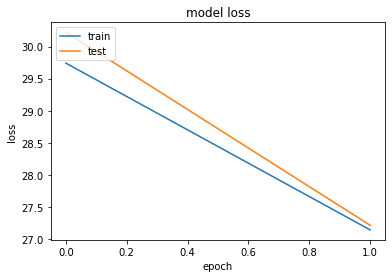

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# model.save("tf_model.h5")

In [28]:
def pre_process_image(path):
    
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape
    print("1. ",img.shape)
    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))
    print("2. ", img.shape)
    
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.
    print("3. ", img.shape)
    return img

In [32]:
act_model.load_weights('C_LSTM_best.hdf5')

# converter = tf.lite.TFLiteConverter.from_keras_model(act_model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [33]:
def predict_output(img):
    # predict outputs on validation images
    img = np.array([img])
    print("4. ",img.shape)
    prediction = act_model.predict(img)
    ## shape (batch_size, num_timesteps, vocab_size)
    print("5. ", prediction.shape)
    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1: 
                print(char_list[int(p)], end = '')
        
        print('\n')

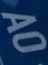



1.  (48, 65)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = SA



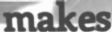



1.  (32, 112)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = aes



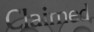



1.  (32, 94)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = es



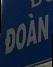



1.  (67, 53)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = ees



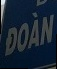



1.  (69, 57)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = ens



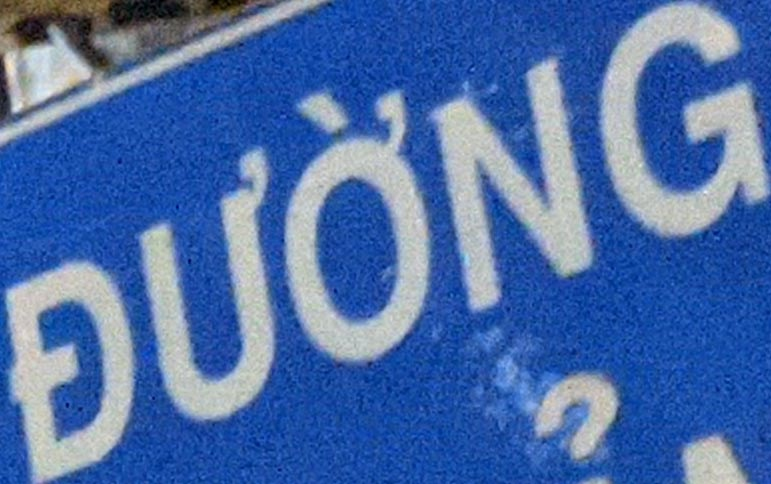



1.  (484, 771)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = SA



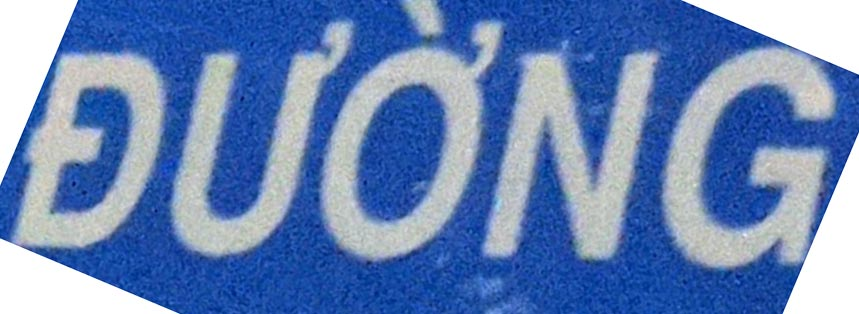



1.  (314, 859)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = A



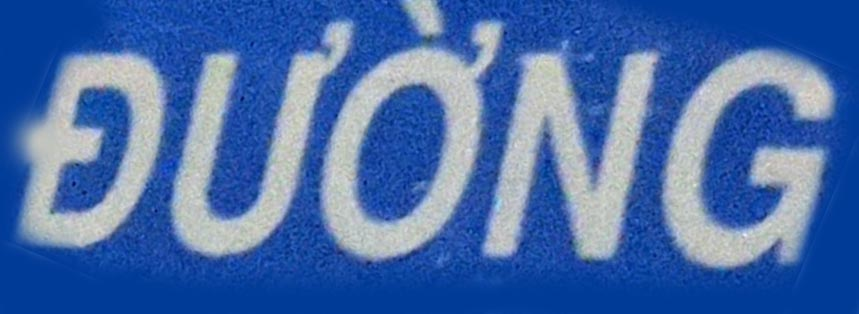



1.  (314, 859)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = A





1.  (31, 124)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = es





1.  (31, 81)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = es





1.  (31, 152)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = boe





1.  (31, 108)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = ns





1.  (31, 96)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = es





1.  (31, 116)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = CO





1.  (31, 151)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = CES





1.  (31, 120)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = MA





1.  (31, 133)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = ans





1.  (31, 108)
2.  (32, 128)
3.  (32, 128, 1)
4.  (1, 32, 128, 1)
5.  (1, 31, 63)
predicted text = C



In [35]:
from IPython.display import display
from random import randrange

for path in os.listdir("test_images"):
    im = Image.open("test_images/" + path)
    display(im)

    print("\n")

    test_img = pre_process_image("test_images/" + path)
    predict_output(test_img)
    
print("===================")

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predict_output(test_img)




In [26]:
## results can be improved with finetuning and including more data :)